In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Toxic_Comment_Classification

Mounted at /content/drive
/content/drive/MyDrive/Toxic_Comment_Classification


In [2]:
!pip install torch
!pip install transformers
!pip install pandas
!pip install scikit-learn

     |████████████████████████████████| 1.4MB 18.2MB/s 
     |████████████████████████████████| 890kB 51.1MB/s 
     |████████████████████████████████| 2.9MB 46.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=565b8b36f911e2722ca70ea784ec4c99f179cca8b137b8cefcc20501e153b36e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os
import time

import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup

In [4]:
batch_size = 32
max_token_len = 256
log_interval = 10

checkpoint_name = 'checkpoint_39500.bin'
checkpoint_storing_path = os.path.join(os.getcwd(), "checkpoints")
checkpoint_full_path = os.path.join(checkpoint_storing_path, checkpoint_name)

DATA_FILENAME = "toxic_comment_details.json"
toxic_comment_details = {}

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [6]:
def compute_metrics(logits, labels):
    preds = torch.zeros_like(logits)
    preds[logits >= 0.5] = 1

    preds_np = preds.cpu().numpy()
    logits_np = logits.cpu().numpy()
    labels_np = labels.cpu().numpy()

    result = []
    for idx in range(labels.shape[1]):
        precision, recall, f1, _ = precision_recall_fscore_support(labels_np[:, idx], preds_np[:, idx], beta=0.5, average="binary")
        acc = accuracy_score(labels_np[:, idx], preds_np[:, idx])
        result.append({
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })

    return result

In [7]:
class ToxicCommentDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_token_len=256, device="cpu", transform=None):
        self.list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

        dataset_df = pd.read_csv(csv_path)
        self.sentence_list = dataset_df["comment_text"].tolist()
        self.labels = torch.from_numpy(dataset_df[list_classes].values).float()

        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.device = device
        self.transform = transform

    def __len__(self):
        return len(self.sentence_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        encoding = tokenizer(self.sentence_list[idx], return_tensors='pt', padding="max_length", truncation=True, max_length=self.max_token_len)
        sample = {
            'input_text': self.sentence_list[idx],
            'input_ids': encoding['input_ids'].view(-1).to(device), 
            'attention_mask': encoding['attention_mask'].view(-1).to(device),
            'label': self.labels[idx].to(device)
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [8]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased', 
    do_lower_case=True, 
)

In [9]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_csv_path = os.path.join(os.getcwd(), 'dataset', 'train.csv')
train_dataset = ToxicCommentDataset(
    train_csv_path, 
    tokenizer, 
    max_token_len, 
    device
)

train_data_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
num_batches = int(len(train_dataset)/batch_size) + 1

Read outputs of the fine-tuned model


In [10]:
# model = BertForSequenceClassification.from_pretrained(
#     checkpoint_full_path, 
#     output_attentions=False,
#     return_dict=True, 
#     num_labels=len(list_classes)
# )
# model.to(device)

In [11]:
# model.eval()

# labels = torch.zeros([0, 6], device=device)
# hats = torch.zeros([0, 6], device=device)

# with torch.no_grad():
#     for batch_idx, batch in enumerate(train_data_loader):
#         input_text = batch['input_text']
#         input_ids = batch['input_ids']
#         attention_mask = batch['attention_mask']
#         label = batch['label']

#         outputs = model(input_ids, attention_mask=attention_mask)
#         y_hat = torch.sigmoid(torch.squeeze(outputs.logits))
#         labels = torch.cat([labels, label])
#         hats = torch.cat([hats, y_hat])

#         print(batch_idx, num_batches)

In [12]:
# hat_np = hats.cpu().numpy()
# print(hat_np.shape)

NameError: ignored

In [13]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

hats_df = pd.DataFrame(hat_np, columns=list_classes)

FileNotFoundError: ignored

In [ ]:
print(hats_df.shape)
hats_df.to_csv("train_hats.csv")

In [ ]:
mix_results = compute_metrics(hats, labels)

In [ ]:
for idx, zipped in enumerate(zip(list_classes, mix_results)):
    toxic_type, mix_result = zipped
    print(toxic_type, ":")
    for key, value in mix_result.items():
        print("    ", key, ":", value)

In [14]:
train_df = pd.read_csv(train_csv_path)

In [15]:
train_df.shape

(159571, 8)

In [16]:
for toxic_type in list_classes:
    print(toxic_type, ": ", train_df[toxic_type].sum())

toxic :  15294
severe_toxic :  1595
obscene :  8449
threat :  478
insult :  7877
identity_hate :  1405


In [17]:
num_pure_comment = (train_df[list_classes].sum(axis=1) == 0).sum()
print("# of pure comment: ", num_pure_comment)

# of pure comment:  143346


In [22]:
result = []
for toxic_type_src in list_classes:
    tmp_row = []
    for toxic_type_tgt in list_classes:
        num_overlap = train_df.loc[(train_df[toxic_type_src] == 1) & (train_df[toxic_type_tgt] == 1), :].shape[0]
        tmp_row.append(num_overlap)

        print(f"# of overlap between {toxic_type_src} and {toxic_type_tgt}: {num_overlap}")

    result.append(tmp_row)

# of overlap between toxic and toxic: 15294
# of overlap between toxic and severe_toxic: 1595
# of overlap between toxic and obscene: 7926
# of overlap between toxic and threat: 449
# of overlap between toxic and insult: 7344
# of overlap between toxic and identity_hate: 1302
# of overlap between severe_toxic and toxic: 1595
# of overlap between severe_toxic and severe_toxic: 1595
# of overlap between severe_toxic and obscene: 1517
# of overlap between severe_toxic and threat: 112
# of overlap between severe_toxic and insult: 1371
# of overlap between severe_toxic and identity_hate: 313
# of overlap between obscene and toxic: 7926
# of overlap between obscene and severe_toxic: 1517
# of overlap between obscene and obscene: 8449
# of overlap between obscene and threat: 301
# of overlap between obscene and insult: 6155
# of overlap between obscene and identity_hate: 1032
# of overlap between threat and toxic: 449
# of overlap between threat and severe_toxic: 112
# of overlap between thre

In [30]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot

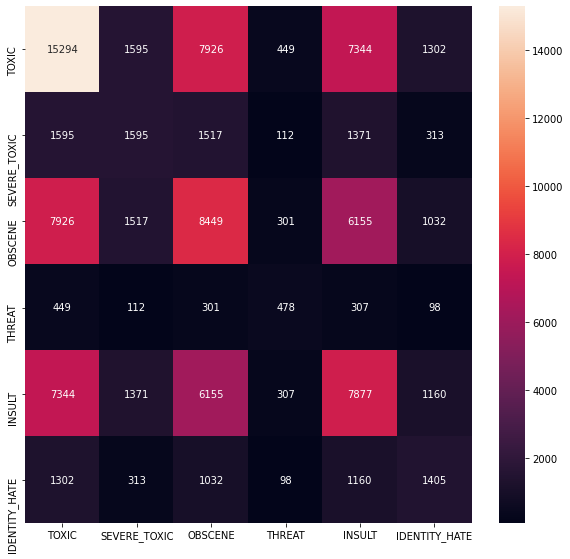

In [33]:
list_classes_upper_case = []

for toxic_type in list_classes:
    list_classes_upper_case.append(toxic_type.upper())

result = np.array(result)
fig, ax = pyplot.subplots(figsize=(10, 9.5))
ax = sns.heatmap(result, annot=True, fmt="d", xticklabels=list_classes_upper_case, yticklabels=list_classes_upper_case, ax=ax)
fig = ax.get_figure()
fig.savefig("overlapping_heatmap.png", dpi=1000) 

[[]]